In [1]:
# Import Modules
import os
import plaid
import requests
import datetime
import pendulum
import json
import pandas as pd
%matplotlib inline
# Ignore the SettingWithCopyWarning
pd.options.mode.chained_assignment = None

In [2]:
# Define JSON prettifier parameters
def pretty_print_response(response):
  print(json.dumps(response, indent=4, sort_keys=True))

In [3]:
# Set Plaid environment variables
PLAID_CLIENT_ID = os.getenv('PLAID_CLIENT_ID')
PLAID_SECRET = os.getenv('PLAID_SECRET')
PLAID_PUBLIC_KEY = os.getenv('PLAID_PUBLIC_KEY')
PLAID_ENV = os.getenv('PLAID_ENV', 'sandbox')
PLAID_PRODUCTS = os.getenv('PLAID_PRODUCTS', 'transactions')

# Plaid Access Token

In this section, you will use the plaid-python api to generate the correct authentication tokens to access data in the free developer Sandbox. This mimics how you might connect to your own account or a customer account, but due to privacy issues, this homework will only require connecting to and analyzing the fake data from the developer sandbox that Plaid provides. 

Complete the following steps to generate an access token:
1. Create a client to connect to plaid
2. Use the client to generate a public token and request the following items: 
['transactions', 'income', 'assets']
3. Exchange the public token for an access token
4. Test the access token by requesting and printing the available test accounts

### 1. Create a client to connect to plaid

In [4]:
# Set Plaid Institition ID
INSTITUTION_ID = "ins_109508"

In [5]:
# Set Plaid development environment
client = plaid.Client(client_id = PLAID_CLIENT_ID, 
                      secret=PLAID_SECRET,
                      public_key=PLAID_PUBLIC_KEY, 
                      environment=PLAID_ENV, 
                      api_version='2019-05-29')

### 2. Generate a public token

In [6]:
# create response from sandbox - detailed in plaid api documentation
create_response = client.Sandbox.public_token.create(
    INSTITUTION_ID, ['transactions'])

### 3. Exchange the public token for an access token

In [7]:
# Set access token from exchange response
response = client.Item.public_token.exchange(create_response['public_token'])
access_token = response['access_token']

### 4. Fetch Accounts

In [8]:
# Create call response for Accounts
accounts_response = client.Accounts.get(access_token)

In [9]:
# Fetch Accounts
accounts = accounts_response['accounts']
pretty_print_response(accounts[:3])

[
    {
        "account_id": "lkBDQkXjGrSGPBzrVdoosQGQ1yDbMpTZmvw6M",
        "balances": {
            "available": 100,
            "current": 110,
            "iso_currency_code": "USD",
            "limit": null,
            "unofficial_currency_code": null
        },
        "mask": "0000",
        "name": "Plaid Checking",
        "official_name": "Plaid Gold Standard 0% Interest Checking",
        "subtype": "checking",
        "type": "depository"
    },
    {
        "account_id": "q34D13mMGdcWrZQp7JkkT8W8BgGA6ycdyqmBx",
        "balances": {
            "available": 200,
            "current": 210,
            "iso_currency_code": "USD",
            "limit": null,
            "unofficial_currency_code": null
        },
        "mask": "1111",
        "name": "Plaid Saving",
        "official_name": "Plaid Silver Standard 0.1% Interest Saving",
        "subtype": "savings",
        "type": "depository"
    },
    {
        "account_id": "Ko3dNoe6KzSpDEPwozJJCRdRxVemkvfVDvZrr"

---

# Account Transactions with Plaid

In this section, you will use the Plaid Python SDK to connect to the Developer Sandbox account and grab a list of transactions. You will need to complete the following steps:


1. Use the access token to fetch the transactions for the last 90 days
2. Print the categories for each transaction type
3. Create a new DataFrame using the following fields from the JSON transaction data: `date, name, amount, category`. (For categories with more than one label, just use the first category label in the list)
4. Convert the data types to the appropriate types (i.e. datetimeindex for the date and float for the amount)

### 1. Fetch the Transactions for the last 90 days

In [10]:
# Set start date and end date for data
start_date = pendulum.now().subtract(days=90).to_date_string()
end_date = pendulum.now().to_date_string()

In [11]:
# Create a call response for transactions
transactions_response = client.Transactions.get(
    access_token,
    start_date = start_date,
    end_date = end_date,
)

In [12]:
# Fetch Transactions
transactions = transactions_response['transactions']
pretty_print_response(transactions[:3])

[
    {
        "account_id": "lkBDQkXjGrSGPBzrVdoosQGQ1yDbMpTZmvw6M",
        "account_owner": null,
        "amount": 12,
        "authorized_date": null,
        "category": [
            "Food and Drink",
            "Restaurants",
            "Fast Food"
        ],
        "category_id": "13005032",
        "date": "2020-05-12",
        "iso_currency_code": "USD",
        "location": {
            "address": null,
            "city": null,
            "country": null,
            "lat": null,
            "lon": null,
            "postal_code": null,
            "region": null,
            "store_number": "3322"
        },
        "name": "McDonald's",
        "payment_channel": "in store",
        "payment_meta": {
            "by_order_of": null,
            "payee": null,
            "payer": null,
            "payment_method": null,
            "payment_processor": null,
            "ppd_id": null,
            "reason": null,
            "reference_number": null
        },
    

### 2. Print the categories for each transaction

In [13]:
# Render data into DataFrame and print 'category' and 'transaction_id' columns
trns_df = pd.DataFrame(transactions)
trns_df[['category','transaction_id']]

,category,transaction_id
0,"[Food and Drink, Restaurants, Fast Food]",y7JKW7ayXQI9NmxrAnllTgXgZjRjPZUyRNDjn
1,"[Food and Drink, Restaurants, Coffee Shop]",9zy7MzvDaLFNrJjZmgddtGoGjXDXAjiRNPEAx
2,"[Food and Drink, Restaurants]",vNeDWNrywjuEdbz3QeLLhVkVG8X8bGcWQ5XNQ
3,"[Transfer, Credit]",Deyqzer6LmUELJ8AMeyyh535bd6dvbHvqyXVg
4,"[Travel, Airlines and Aviation Services]",JpBxNpG6qruDoqVbArXXIvwv6RrRA6fd875aj
5,"[Travel, Taxi]",RKjMyKe6aNSQ1qbZkNggheVepGzG5pcRVdGDg
6,"[Food and Drink, Restaurants]",klzDQleP6KC6NgrnoxzzFn6n1kqkQ1iW5P8Nn
7,[Payment],Ko3dNoe6KzSpDEPwozJJCRdRen7nyeiVXwme7
8,"[Food and Drink, Restaurants, Fast Food]",q34D13mMGdcWrZQp7JkkT8W8G7o7eGudKbV95
9,"[Shops, Sporting Goods]",lkBDQkXjGrSGPBzrVdoosQGQDJAJlDiZ39rjx


### 3. Create a new DataFrame using the following fields from the JSON transaction data: date, name, amount, category. 

(For categories with more than one label, just use the first category label in the list)

In [14]:
# Render new DataFrame with 'date', 'name', 'amount', and 'category' columns
trns_df_cln = trns_df[['date','name','amount','category']]
trns_df_cln

,date,name,amount,category
0,2020-05-12,McDonald's,12.00,"[Food and Drink, Restaurants, Fast Food]"
1,2020-05-12,Starbucks,4.33,"[Food and Drink, Restaurants, Coffee Shop]"
2,2020-05-11,SparkFun,89.40,"[Food and Drink, Restaurants]"
3,2020-05-10,INTRST PYMNT,-4.22,"[Transfer, Credit]"
4,2020-04-30,United Airlines,500.00,"[Travel, Airlines and Aviation Services]"
5,2020-04-28,Uber,6.33,"[Travel, Taxi]"
6,2020-04-25,Tectra Inc,500.00,"[Food and Drink, Restaurants]"
7,2020-04-24,AUTOMATIC PAYMENT - THANK,2078.50,[Payment]
8,2020-04-24,KFC,500.00,"[Food and Drink, Restaurants, Fast Food]"
9,2020-04-24,Madison Bicycle Shop,500.00,"[Shops, Sporting Goods]"


### 4. Convert the data types to the appropriate types 

(i.e. datetimeindex for the date and float for the amount)

In [15]:
# Get data types of DataFrame
trns_df_cln.dtypes

date         object
name         object
amount      float64
category     object
dtype: object

In [16]:
# Convert 'category' column from list to string
trns_df_cln['category'] = trns_df_cln['category'].apply(', '.join)

In [17]:
# Convert 'date' column from string to datetime
trns_df_cln['date'] = pd.to_datetime(trns_df_cln['date'])
trns_df_cln.dtypes

date        datetime64[ns]
name                object
amount             float64
category            object
dtype: object

In [18]:
# Show that 'category' column is now string
trns_df_cln.head(5)

,date,name,amount,category
0,2020-05-12,McDonald's,12.00,"Food and Drink, Restaurants, Fast Food"
1,2020-05-12,Starbucks,4.33,"Food and Drink, Restaurants, Coffee Shop"
2,2020-05-11,SparkFun,89.40,"Food and Drink, Restaurants"
3,2020-05-10,INTRST PYMNT,-4.22,"Transfer, Credit"
4,2020-04-30,United Airlines,500.00,"Travel, Airlines and Aviation Services"


---

# Income Analysis with Plaid

In this section, you will use the Plaid Sandbox to complete the following:
1. Determine the previous year's gross income and print the results
2. Determine the current monthly income and print the results
3. Determine the projected yearly income and print the results

In [19]:
# Create call response for income
income_response = client.Income.get(access_token)

In [20]:
# set response tp transactions variable and print first element from list
income = income_response['income']
pretty_print_response(income)

{
    "income_streams": [
        {
            "confidence": 0.99,
            "days": 720,
            "monthly_income": 500,
            "name": "UNITED AIRLINES"
        }
    ],
    "last_year_income": 6500,
    "last_year_income_before_tax": 7893,
    "max_number_of_overlapping_income_streams": 1,
    "number_of_income_streams": 1,
    "projected_yearly_income": 6085,
    "projected_yearly_income_before_tax": 7389
}


In [21]:
# Determine the previous year's gross income and print the results
last_yr_gross_inc = '{:,.2f}'.format(income['last_year_income_before_tax'])
print(f'The previous year\'s gross income was ${last_yr_gross_inc}.')

The previous year's gross income was $7,893.00.


In [22]:
# Determine the current monthly income and print the results
curr_mnthly_inc = '{:,.2f}'.format(income['income_streams'][0]["monthly_income"])
print(f'The current monthly income is ${curr_mnthly_inc}.')

The current monthly income is $500.00.


In [23]:
# Determine the projected yearly income and print the results
prjctd_yrly_inc = '{:,.2f}'.format(income['projected_yearly_income'])
prjctd_yrly_inc_gross = '{:,.2f}'.format(income['projected_yearly_income_before_tax'])

print(f'The projected yearly income is ${prjctd_yrly_inc}. \n\
The projected yearly gross income is ${prjctd_yrly_inc_gross}.')

The projected yearly income is $6,085.00. 
The projected yearly gross income is $7,389.00.


---

# Budget Analysis
In this section, you will use the transactions DataFrame to analyze the customer's budget

1. Calculate the total spending per category and print the results (Hint: groupby or count transactions per category)
2. Generate a bar chart with the number of transactions for each category 
3. Calculate the expenses per month
4. Plot the total expenses per month

### Calculate the expenses per category

In [24]:
# Calculate the total spending per category and print the results
spndng_per_cat = trns_df_cln.groupby('category').sum()
spndng_per_cat

,amount
category,
"Food and Drink, Restaurants",1768.20
"Food and Drink, Restaurants, Coffee Shop",17.32
"Food and Drink, Restaurants, Fast Food",1548.00
Payment,6235.50
"Payment, Credit Card",75.00
"Recreation, Gyms and Fitness Centers",235.50
"Shops, Sporting Goods",1500.00
"Transfer, Credit",-12.66
"Transfer, Debit",17550.00


[Text(0, 0, 'Food and Drink, Restaurants'),
 Text(0, 0, 'Food and Drink, Restaurants, Coffee Shop'),
 Text(0, 0, 'Food and Drink, Restaurants, Fast Food'),
 Text(0, 0, 'Payment'),
 Text(0, 0, 'Payment, Credit Card'),
 Text(0, 0, 'Recreation, Gyms and Fitness Centers'),
 Text(0, 0, 'Shops, Sporting Goods'),
 Text(0, 0, 'Transfer, Credit'),
 Text(0, 0, 'Transfer, Debit'),
 Text(0, 0, 'Transfer, Deposit'),
 Text(0, 0, 'Travel, Airlines and Aviation Services'),
 Text(0, 0, 'Travel, Taxi')]

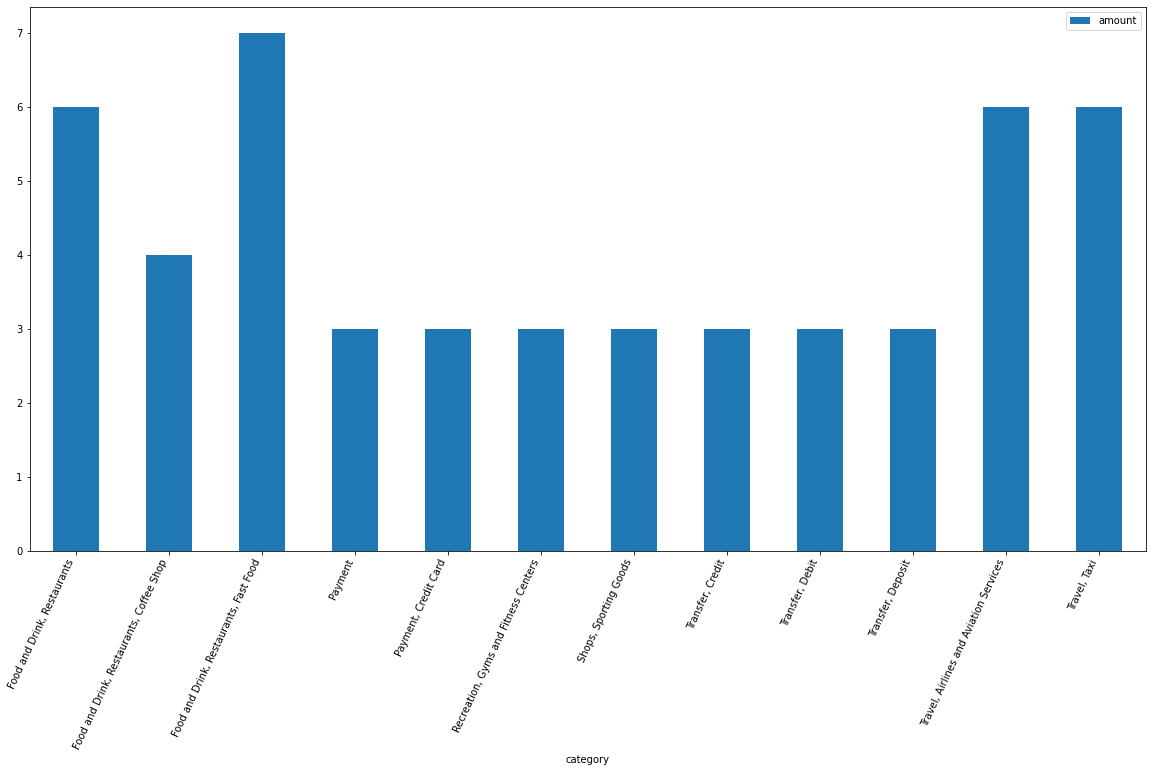

In [25]:
# Generate a bar chart with the number of transactions for each category
trns_per_cat = trns_df_cln.groupby('category').count()
chart = trns_per_cat[['amount']].plot(kind='bar', figsize=(20,10))
chart.set_xticklabels(chart.get_xticklabels(), rotation=65, horizontalalignment='right')

### Calculate the expenses per month

In [26]:
#Calculate the expenses per month
trns_df_cln.set_index(['date'], inplace=True)
mnthly_exp = trns_df_cln['amount'].groupby(pd.Grouper(freq='M')).sum()

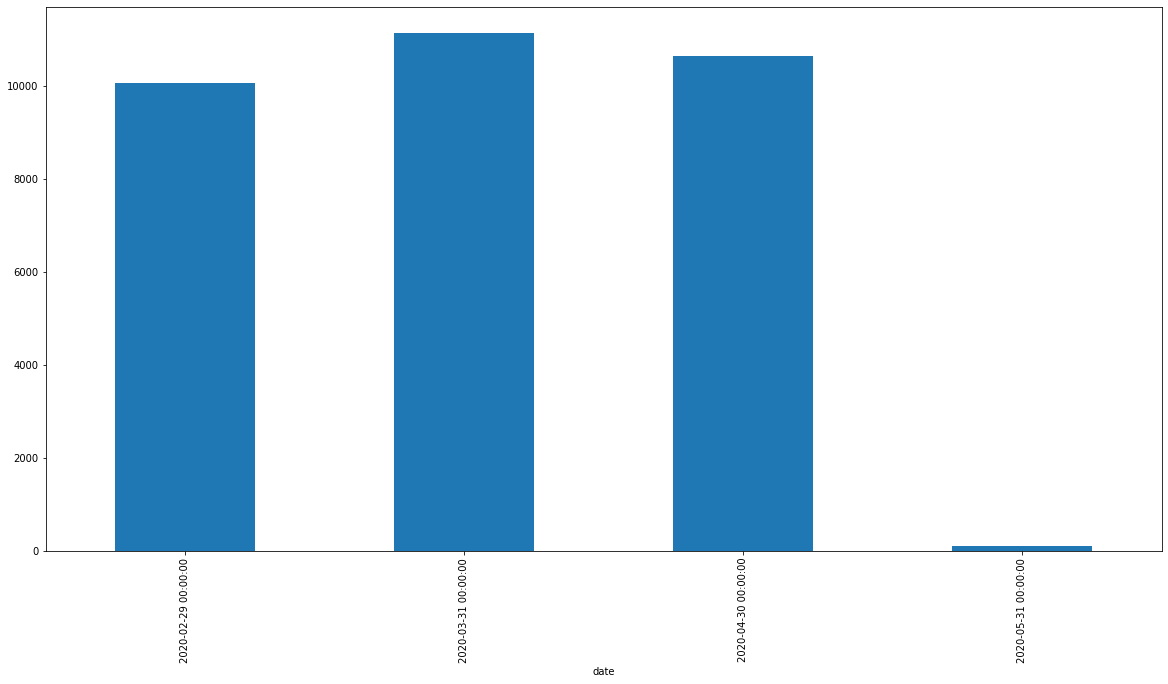

In [27]:
# Plot the total expenses per month
mnthly_exp.plot(kind='bar', figsize=(20,10))